# 使用PCA 及KMeans聚类
本文不会用到任何预测模型（SVM、Regession等），这是单纯的数据探索，希望足够简明地阐述PCA的思想，以及使用聚类，从中提取有意义的相关性。

PCA 的一个高级描述是，它是一个降维方法，通过投影到低维空间的方式减少原始数据集的特征数目。比如原始数据有72维，可以降低到9维。

问题是，降维后，如何从中得到新的数据？聚类。

1. 数据清洗，处理缺失值，并只取数值列；特征标准化。
2. 采用解释性方差Explained Variance 度量PCA
3. 实现PCA
4. KMeans 聚类

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
movie = pd.read_csv('movie_metadata.csv')
movie.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
movie.shape

(5043, 28)

In [5]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

先只采用数值列：

In [6]:
movie_num  = movie[[x for x in movie.columns if movie[x].dtypes != 'object']]

In [7]:
movie_num.isnull().sum()

num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_1_facebook_likes         7
gross                        884
num_voted_users                0
cast_total_facebook_likes      0
facenumber_in_poster          13
num_user_for_reviews          21
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

粗略地只用0填充缺失值：

In [8]:
movie_num = movie_num.fillna(value=0, axis=1)

数据标准化：

In [9]:
X = movie_num.values
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

用hexbin图初步查看两个变量间的相关性

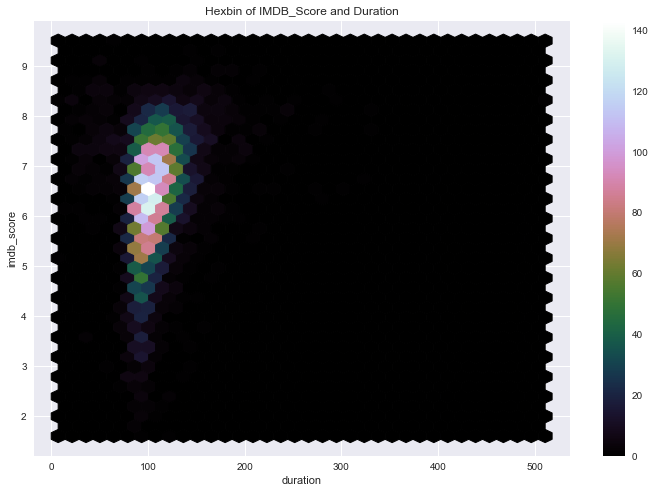

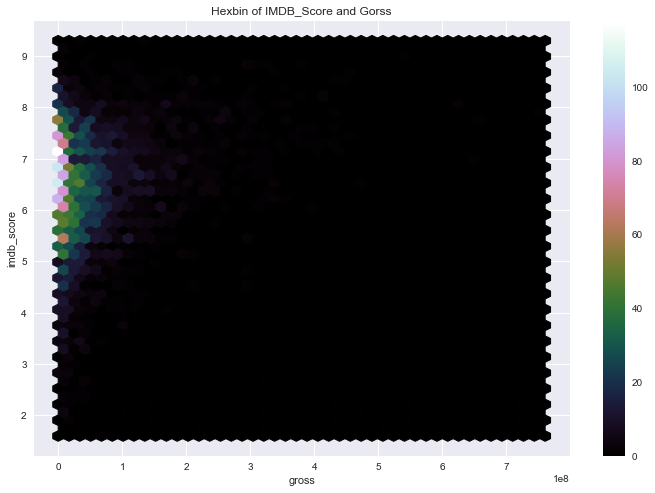

In [10]:
movie.plot(y='imdb_score',x='duration',kind='hexbin',gridsize=35,sharex=False,colormap='cubehelix',
          title = 'Hexbin of IMDB_Score and Duration',figsize=(12,8))
movie.plot(y='imdb_score',x='gross',kind='hexbin',gridsize=45,sharex=False,colormap='cubehelix',
          title='Hexbin of IMDB_Score and Gorss', figsize=(12,8))

PCA的惯例，用到heatmap，查看特征两两之间的相关性:

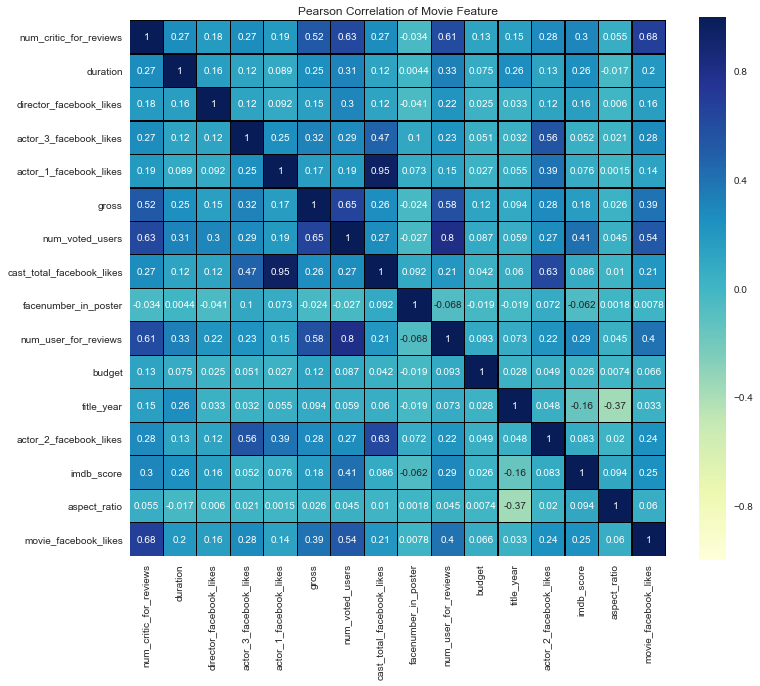

In [11]:
f,ax=plt.subplots(figsize=(12,10))
plt.title('Pearson Correlation of Movie Feature')
sns.heatmap(movie_num.astype(float).corr(),linewidths=0.25,vmax=1.0,square=True,cmap="YlGnBu",linecolor='black',
           annot=True)

一些深色区域表明特征间正线性相关。对于线性关系，我们就可以采用PCA

## 2. EXPLAINED VARIANCE MEASURE

计算协方差矩阵的特征向量和特征值：

    np.linalg.eig

In [12]:
mean_vec = np.mean(X_std,axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat) #  eigenvalues and eigenvectors

创建一个元组列表，元组由特征值和特征向量 构成，从而列表元素排列按特征值从高到低排列，并能用特征值计算 单个解释方差 及 累积解释方差

In [13]:
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

<Container object of 16 artists>

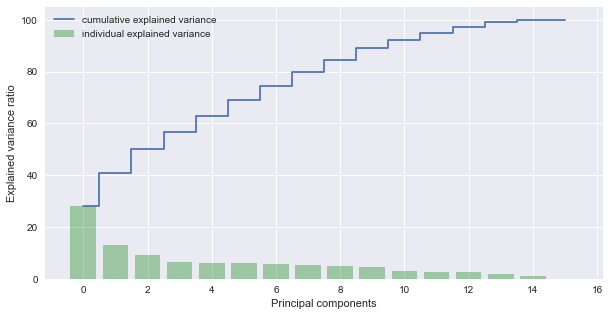

In [14]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.bar(range(16), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(16), cum_var_exp,where='mid',label='cumulative explained variance') # 阶梯图
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

上图表明，大约90%的方差可被 9 Principle Components 解释

## 3. PRINCIPAL COMPONENT ANALYSIS
粗略判断出我们要投影到几个分量（维度）后，用sklearn 的PCA模块来实现

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
x_9d = pca.fit_transform(X_std) # 将原来的维度PCA降维到9维

用散点图可视化降维后的前2个分量：

(-10, 30)

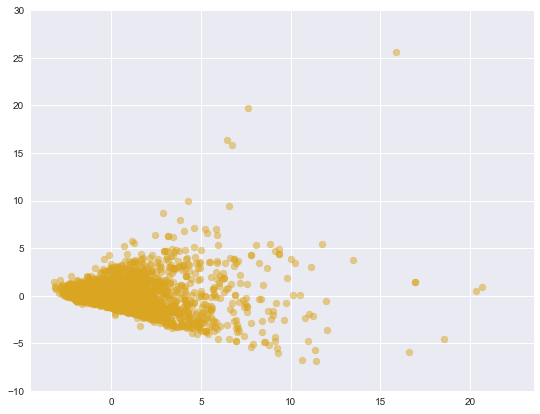

In [16]:
plt.figure(figsize=(9,7))
plt.scatter(x_9d[:,0],x_9d[:,1],c='goldenrod',alpha=0.5)
plt.ylim(-10,30)
plt.show()

仅用2维，貌似看不出存在不同的clusters

## 4. VISUALISATIONS WITH KMEANS CLUSTERING

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)  # 假设有3个clusters
X_clustered = kmeans.fit_predict(x_9d)

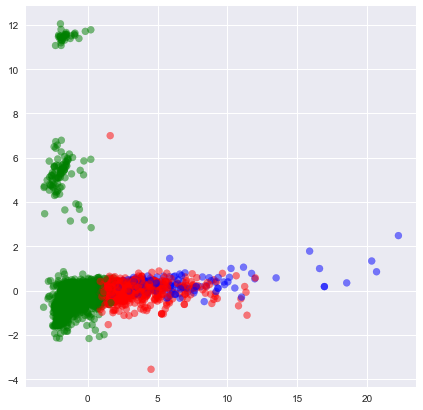

In [18]:
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=3)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_9d)

# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_9d[:,0],x_9d[:,2], c= label_color, alpha=0.5)  
plt.show()

取第1和第3维数据可视化效果比较好，但其他维度组合呢？

用seaborn 的pairplot：

/Users/linzhun/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/linzhun/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


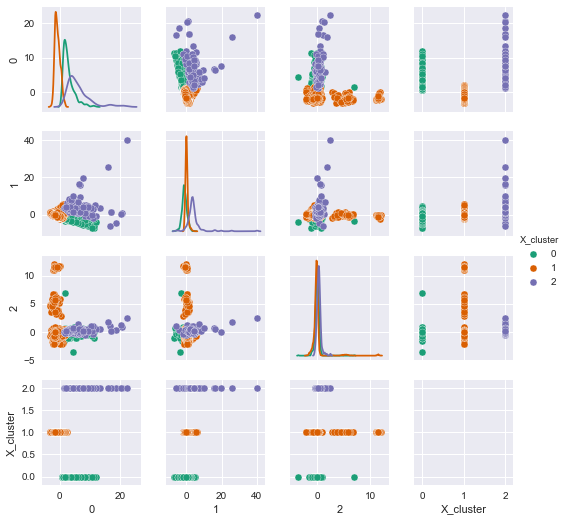

In [19]:
df = pd.DataFrame(x_9d) # 创建一个DataFrame 方便pairplot
df = df[[0,1,2]] #只可视化 前4个投影分量间的关系
df['X_cluster'] = X_clustered
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)